In [1]:
import os
import torch
import numpy as np
from torch import nn
from PIL import Image 
from glob import glob
from torchvision import models
import torch.nn.functional as F
# Build data loader
from tqdm import tqdm
from torchvision import transforms
from collections import OrderedDict
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import models
!pip install torchsummary
from torchsummary import summary


In [2]:
torch.cuda.empty_cache()
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [3]:
#Convolution block
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=2, padding=1):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding
        )
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.batch_norm(x)
        return self.relu(x)


In [4]:
#SpatialPath-3convblock
class SpatialPath(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = ConvBlock(in_channels=3, out_channels=64)
        self.conv2 = ConvBlock(in_channels=64, out_channels=128)
        self.conv3 = ConvBlock(in_channels=128, out_channels=256)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return self.conv3(x)

In [5]:
#ContextPath
class ContextPath(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        self.features = models.resnet18(pretrained=pretrained)
        self.conv1 = self.features.conv1
        self.bn1 = self.features.bn1
        self.relu = self.features.relu
        self.max_pool = self.features.maxpool
        self.layer1 = self.features.layer1
        self.layer2 = self.features.layer2
        self.layer3 = self.features.layer3
        self.layer4 = self.features.layer4
        self.avg_pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))

    def forward(self, x_input):
        x = self.conv1(x_input)
        x = self.relu(self.bn1(x))
        x = self.max_pool(x)

        #1/4
        feature1 = self.layer1(x)

        #1/8
        feature2 = self.layer2(feature1)

        #1/16
        feature3 = self.layer3(feature2)

        #1/32
        feature4 = self.layer4(feature3)

        #Average Pooling
        tail = self.avg_pool(feature4)
        return feature3, feature4, tail


In [6]:
#ARM
class AttentionRefinementModule(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.sigmoid = nn.Sigmoid()
        self.in_channels = in_channels

    def forward(self, x_input):
        x = self.avg_pool(x_input)
        assert self.in_channels == x.size(1), 'in_channels and out_channels should all be {}'.format(x.size(1))
        x = self.conv(x)
        x = self.bn(x)
        x = self.sigmoid(x)
        return torch.mul(x_input, x)


In [7]:
#FFM
class FeatureFusionModule(nn.Module):
    def __init__(self, num_classes, in_channels):
        super().__init__()
        self.in_channels = in_channels
        self.conv_block = ConvBlock(in_channels=in_channels, out_channels=num_classes, stride=1)
        self.conv1 = nn.Conv2d(in_channels=num_classes, out_channels=num_classes, kernel_size=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=num_classes, out_channels=num_classes, kernel_size=1)
        self.sigmoid = nn.Sigmoid()
        self.avg_pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
    def forward(self, x_input_1, x_input_2):
        x = torch.cat((x_input_1, x_input_2), dim=1)
        assert self.in_channels == x.size(1), 'in_channels of ConvBlock should be {}'.format(x.size(1))
        feature = self.conv_block(x)
        x = self.avg_pool(feature)
        x = self.relu(self.conv1(x))
        x = self.sigmoid(self.conv2(x))
        x = torch.mul(feature, x)
        return torch.add(feature, x)


In [8]:
class CMDataset(Dataset):
    # Default encoding for pixel value, class name, and class color
    color_encoding = [
        ('Bus Lane', (0, 255, 255)),
        ('Cycle Lane', (0, 128, 255)),
        ('Diamond', (178, 102, 255)),
        ('Junction Box', (255, 255, 51)),
        ('Left Arrow', (255, 102, 178)),
        ('Pedestrian Crossing', (255, 255, 0)),
        ('Right Arrow', (255, 0, 127)),
        ('Straight Arrow', (255, 0, 255)),
        ('Slow', (0, 255, 0)),
        ('Straight-Left Arrow', (255, 128, 0)),
        ('Straight-Right Arrow', (255, 0, 0)),
        ('Background', (0, 0, 0))
    ]
    def __init__(self, mode='train', num_classes=12):
        self.mode = mode
        self.num_classes = num_classes
        # Normailization
        self.normalize = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ])

        self.DATA_PATH = os.path.join(os.getcwd(), '')

        self.train_path, self.val_path, self.test_path = [os.path.join(self.DATA_PATH, x) for x in ['train', 'val', 'test']]

        if self.mode == 'train':
            self.data_files = self.get_files(self.train_path)
            self.label_files = [self.get_label_file(f, 'train', 'train_labels') for f in self.data_files]
        elif self.mode == 'val':
            self.data_files = self.get_files(self.val_path)
            self.label_files = [self.get_label_file(f, 'val', 'val_labels') for f in self.data_files]
        elif self.mode == 'test':
            self.data_files = self.get_files(self.test_path)
            self.label_files = [self.get_label_file(f, 'test', 'test_labels') for f in self.data_files]
        else:
            raise RuntimeError("Unexpected dataset mode. "
                               "Supported modes are: train, val and test")


    def get_files(self, data_folder):
        """
            Return all files in folder with extension
        """
        return glob("{}/*.{}".format(data_folder, 'jpg'))

    def get_label_file(self, data_path, data_dir, label_dir):
        """
        Return the label path for the data_path file
        """
        data_path = data_path.replace(data_dir, label_dir)
        fname, _ = data_path.rsplit('.', 1) 
        return "{}.png".format(fname)

    def image_loader(self, data_path, label_path):
        data = Image.open(data_path)
        label = Image.open(label_path)

        data = data.resize((720,720), Image.BILINEAR) 
        label = label.resize((720,720), Image.NEAREST)  

        return data, label

    def label_for_cross_entropy(self, label):
        """
            Convert label image to matrix classes for apply cross entropy loss.
            Return semantic index, label in enumemap of H x W x class
        """
        semantic_map = np.zeros(label.shape[:-1])
        semantic_map.fill(self.num_classes - 1)

        for class_index, color_info in enumerate(self.color_encoding):
            color = color_info[1]
            equality = np.equal(label, color)
            class_map = np.all(equality, axis=-1)
            semantic_map[class_map] = class_index
        return semantic_map


    def __getitem__(self, index):
        """
            Args:
            - index (``int``): index of the item in the dataset
            Returns:
            A tuple of ``PIL.Image`` (image, label) where label is the ground-truth
            of the image.
        """

        data_path, label_path = self.data_files[index], self.label_files[index]
        img, label = self.image_loader(data_path, label_path)

        #Apply normalization 
        img = self.normalize(img)
        #Convert label for cross entropy
        label = np.array(label)
        label = self.label_for_cross_entropy(label)
        label = torch.from_numpy(label).long()

        return img, label

    def __len__(self):
        """
            Return len of dataset
        """
        return len(self.data_files)

In [9]:
#BiSeNet
class BiSeNet(nn.Module):
    def __init__(self, num_classes, training=True):
        super().__init__()
        self.training = training
        self.spatial_path = SpatialPath()
        self.context_path = ContextPath()
        self.arm1 = AttentionRefinementModule(in_channels=256, out_channels=256)
        self.arm2 = AttentionRefinementModule(in_channels=512, out_channels=512)
        self.supervision1 = nn.Conv2d(in_channels=256, out_channels=num_classes, kernel_size=1)
        self.supervision2 = nn.Conv2d(in_channels=512, out_channels=num_classes, kernel_size=1)
        self.ffm = FeatureFusionModule(num_classes=num_classes, in_channels=1024)
        self.conv = nn.Conv2d(in_channels=num_classes, out_channels=num_classes, kernel_size=1)

    def forward(self, x_input):
        sp_out = self.spatial_path(x_input)
        feature1, feature2, tail = self.context_path(x_input)
        feature1, feature2 = self.arm1(feature1), self.arm2(feature2)
        feature2 = torch.mul(feature2, tail)
        size2d_out = sp_out.size()[-2:]
        feature1 = F.interpolate(feature1, size=size2d_out, mode='bilinear')
        feature2 = F.interpolate(feature2, size=size2d_out, mode='bilinear')
        context_out = torch.cat((feature1, feature2), dim=1)
        combine_feature = self.ffm(sp_out, context_out)
        bisenet_out = F.interpolate(combine_feature, scale_factor=8, mode='bilinear')
        bisenet_out = self.conv(bisenet_out)
        if self.training is True:
            feature1_sup = self.supervision1(feature1)
            feature2_sup = self.supervision2(feature2)
            feature1_sup = F.interpolate(feature1_sup, size=x_input.size()[-2:], mode='bilinear')
            feature2_sup = F.interpolate(feature2_sup, size=x_input.size()[-2:], mode='bilinear')
            return bisenet_out, feature1_sup, feature2_sup
        return bisenet_out

In [ ]:
EPOCHS = 100
LEARNING_RATE = 0.0001
BATCH_SIZE = 8
CHECKPOINT_STEP = 2
VALIDATE_STEP = 1

NUM_CLASSES = 12

model = BiSeNet(num_classes=NUM_CLASSES, training=True)
model = model.cuda()

#Load train data
dataset_train = CMDataset(mode='train')
dataloader_train = DataLoader(
    dataset_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True
)

#Load validate data
dataset_val = CMDataset(mode='val')
dataloader_val = DataLoader(
    dataset_val,
    batch_size=1,
    shuffle=True
)

optimizer = torch.optim.Adam(model.parameters(), LEARNING_RATE)
loss_func = torch.nn.CrossEntropyLoss()

In [11]:
from sklearn.metrics import confusion_matrix
import numpy as np

In [12]:
def reverse_one_hot(image):
    image = image.permute(1, 2, 0)
    x = torch.argmax(image, dim=-1)
    return x

def compute_accuracy(pred, label):
    pred = pred.flatten()
    label = label.flatten()
    total = len(label)
    count = 0.0
    for i in range(total):
        if pred[i] == label[i]:
            count = count + 1.0
    return float(count) / float(total)

def fast_hist(a, b, n):
    k = (a >= 0) & (a < n)
    return np.bincount(n * a[k].astype(int) + b[k], minlength=n ** 2).reshape(n, n)


def per_class_iu(hist):
    epsilon = 1e-5
    return (np.diag(hist) + epsilon) / (hist.sum(1) + hist.sum(0) - np.diag(hist) + epsilon)

def val(model, dataloader):
    accuracy_arr = []

    hist = np.zeros((NUM_CLASSES, NUM_CLASSES))

    with torch.no_grad():
        model.eval()
        print('Starting validate')

        for i, (val_data, val_label) in enumerate(dataloader):
            val_data = val_data.cuda()
            val_output = model(val_data).squeeze()
            val_output = reverse_one_hot(val_output)
            val_output = np.array(val_output.cpu())
            val_label = val_label.squeeze()
            val_label = np.array(val_label.cpu())
            accuracy = compute_accuracy(val_output, val_label)
            hist += fast_hist(val_label.flatten(), val_output.flatten(), NUM_CLASSES)
            accuracy_arr.append(accuracy)
        miou_list = per_class_iu(hist)[:-1]
        mean_accuracy, mean_iou = np.mean(accuracy_arr), np.mean(miou_list)
        print('Mean accuracy: {} Mean IoU: {}'.format(mean_accuracy, mean_iou))
        return mean_accuracy, mean_iou

In [ ]:
model = BiSeNet(num_classes=NUM_CLASSES, training=True).cuda()
#model.load_state_dict(torch.load('/kaggle/input/checkpoint14-5/pytorch/37epochsnext/1/next37epochs.pth')) 

#Train
torch.cuda.empty_cache()
max_miou = 0

with open('/kaggle/working/train_val_metrics.txt', 'w') as f:
    f.write("Epoch\tTrain Loss\tTrain IoU\tVal Loss\tVal IoU\n")

    for epoch in range(EPOCHS):
        model.train()
        tq = tqdm(total=len(dataloader_train) * BATCH_SIZE)
        tq.set_description('Epoch {}/{}'.format(epoch, EPOCHS))

        loss_record = []

        for i, (data, label) in enumerate(dataloader_train):
            data = data.cuda()
            label = label.cuda()
            output, output_sup1, output_sup2 = model(data)
            loss1 = loss_func(output, label)
            loss2 = loss_func(output_sup1, label)
            loss3 = loss_func(output_sup2, label)
            loss = loss1 + loss2 + loss3
            tq.update(BATCH_SIZE)
            tq.set_postfix(loss='%.6f' % loss)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_record.append(loss.item())
        tq.close()
        loss_train_mean = np.mean(loss_record)
        print('loss for train : %f' % (loss_train_mean))

        intif epoch % CHECKPOINT_STEP == 0:
            torch.save(model.state_dict(), '/kaggle/working/lastest_model.pth')

        if epoch % VALIDATE_STEP == 0:
            mean_accuracy, mean_iou = val(model, dataloader_val)
            if mean_iou > max_miou:
                max_miou = mean_iou
                print('Save best model with mIoU = {}'.format(mean_iou))
                torch.save(model.state_dict(), '/kaggle/working/best_model.pth')

            with open('/kaggle/working/train_val_metrics.txt', 'a') as f:
                f.write(f"{epoch}\t{loss_train_mean}\t{mean_iou}\t{mean_accuracy}\t{mean_iou}\n")


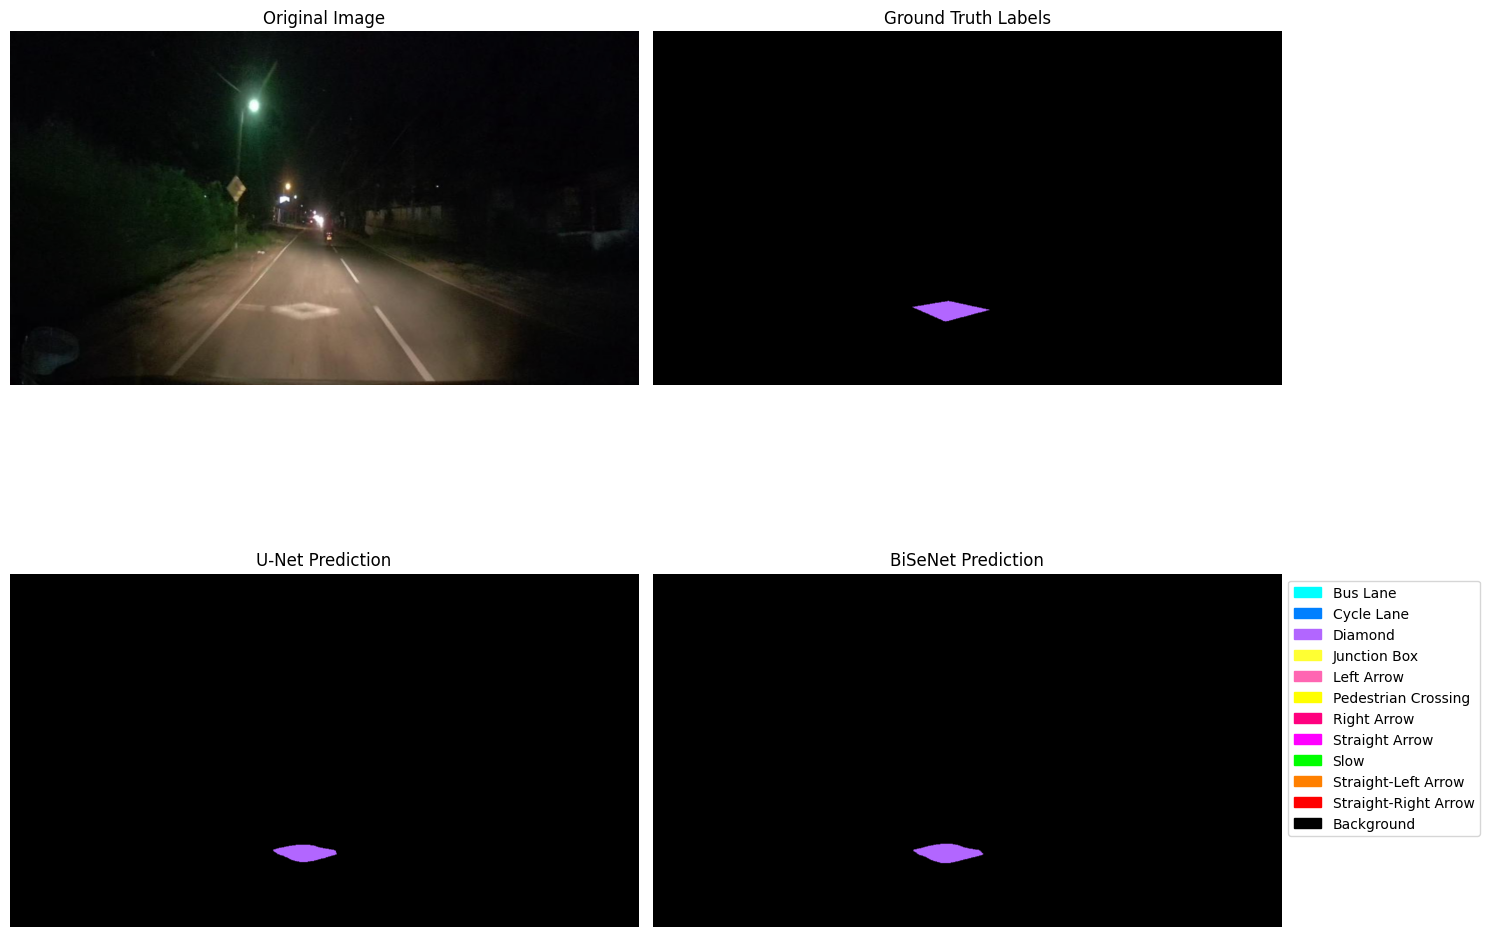

In [89]:
import random
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import torch
import numpy as np
from torch.utils.data import DataLoader
import cv2
# Color encoding
color_encoding = [
    ('Bus Lane', (0, 255, 255)),
    ('Cycle Lane', (0, 128, 255)),
    ('Diamond', (178, 102, 255)),
    ('Junction Box', (255, 255, 51)),
    ('Left Arrow', (255, 102, 178)),
    ('Pedestrian Crossing', (255, 255, 0)),
    ('Right Arrow', (255, 0, 127)),
    ('Straight Arrow', (255, 0, 255)),
    ('Slow', (0, 255, 0)),
    ('Straight-Left Arrow', (255, 128, 0)),
    ('Straight-Right Arrow', (255, 0, 0)),
    ('Background', (0, 0, 0))
]

# Convert RGB color tuples to Matplotlib color format
color_legend = [(label, tuple(color[i] / 255 for i in range(3))) for label, color in color_encoding]

# Load the BiSeNet model
model_bisenet = BiSeNet(num_classes=NUM_CLASSES, training=False)
model_bisenet.load_state_dict(torch.load('', map_location=torch.device('cpu')))
model_bisenet.eval()

# Load the U-Net model
model_unet = BiSeNet(num_classes=NUM_CLASSES)  # Initialize U-Net model
model_unet.load_state_dict(torch.load('', map_location=torch.device('cpu')))
model_unet.eval()

# Prepare the validation dataset DataLoader
dataloader_val = DataLoader(dataset_val, batch_size=1, shuffle=True)

# Get a random image from the validation dataset
random_index = random.randint(0, len(dataset_val) - 1)
random_data, random_label = dataset_val[random_index]
random_data = random_data.unsqueeze(0)  # Add batch dimension

# Perform prediction with both models on CPU
with torch.no_grad():
    # BiSeNet prediction
    output_bisenet = model_bisenet(random_data)
    predicted_class_labels_bisenet = torch.argmax(output_bisenet.squeeze(), dim=0).numpy()

    # U-Net prediction
    output_unet = model_unet(random_data)
    predicted_class_labels_unet = torch.argmax(output_unet.squeeze(), dim=0).numpy()

# Convert predicted labels to RGB images for visualization
def labels_to_rgb(predicted_class_labels):
    rgb_labels = np.zeros((predicted_class_labels.shape[0], predicted_class_labels.shape[1], 3), dtype=np.uint8)
    for class_index, color_info in enumerate(color_encoding):
        color = color_info[1]
        rgb_labels[predicted_class_labels == class_index] = color
    return rgb_labels

predicted_rgb_labels_bisenet = labels_to_rgb(predicted_class_labels_bisenet)
predicted_rgb_labels_unet = labels_to_rgb(predicted_class_labels_unet)

# Convert ground truth labels to RGB image for visualization
ground_truth_rgb_labels = labels_to_rgb(random_label)

# Resize images to 1920x1080 for better visualization
desired_size = (1920, 1080)

# Resize predicted and ground truth images
predicted_rgb_resized_bisenet = Image.fromarray(predicted_rgb_labels_bisenet).resize(desired_size, Image.NEAREST)
predicted_rgb_resized_unet = Image.fromarray(predicted_rgb_labels_unet).resize(desired_size, Image.NEAREST)
ground_truth_rgb_resized = Image.fromarray(ground_truth_rgb_labels).resize(desired_size, Image.NEAREST)

# Mean and std used for normalization
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# Function to denormalize the image
def denormalize(tensor_image):
    """
    Denormalizes the input tensor image by reversing the normalization.
    """
    tensor_image = tensor_image.permute(1, 2, 0).numpy()  # Change to HxWxC format
    tensor_image = std * tensor_image + mean  # Denormalize
    tensor_image = np.clip(tensor_image, 0, 1)  # Clip to ensure values are within [0, 1]
    return tensor_image

# Denormalize the original image
denormalized_image = denormalize(random_data.squeeze())

# Resize the denormalized image for better visualization
denormalized_image_resized = cv2.resize(denormalized_image, (1920, 1080))

# Create legend handles
legend_handles = [mpatches.Patch(color=color[1], label=color[0]) for color in color_legend]

# Plot the denormalized image, ground truth labels, and predictions from both models
plt.figure(figsize=(15, 12))

# First row: Denormalized Original Image and Ground Truth
plt.subplot(2, 2, 1)
plt.title('Original Image')
plt.imshow(denormalized_image_resized)
plt.axis('off')

plt.subplot(2, 2, 2)
plt.title('Ground Truth Labels')
plt.imshow(ground_truth_rgb_resized)
plt.axis('off')

# Second row: U-Net and BiSeNet predictions
plt.subplot(2, 2, 3)
plt.title('U-Net Prediction')
plt.imshow(predicted_rgb_resized_unet)
plt.axis('off')

plt.subplot(2, 2, 4)
plt.title('BiSeNet Prediction')
plt.imshow(predicted_rgb_resized_bisenet)
plt.axis('off')

# Add legend

plt.legend(handles=legend_handles, loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()
